# Assignment 11: Akash

In [1]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import urllib2
import scipy.stats as stats

np.set_printoptions(precision=3, suppress=True)
url = ('https://raw.githubusercontent.com/Upward-Spiral-Science'
       '/data/master/syn-density/output.csv')
data = urllib2.urlopen(url)
csv = np.genfromtxt(data, delimiter=",")[1:] # don't want first row (labels)

# chopping data based on thresholds on x and y coordinates
x_bounds = (409, 3529)
y_bounds = (1564, 3124)

def check_in_bounds(row, x_bounds, y_bounds):
    if row[0] < x_bounds[0] or row[0] > x_bounds[1]:
        return False
    if row[1] < y_bounds[0] or row[1] > y_bounds[1]:
        return False
    if row[3] == 0:
        return False
    
    return True

indices_in_bound, = np.where(np.apply_along_axis(check_in_bounds, 1, csv,
                                                 x_bounds, y_bounds))
data_thresholded = csv[indices_in_bound]
n = data_thresholded.shape[0]


def synapses_over_unmasked(row):
    s = (row[4]/row[3])*(64**3)
    return [row[0], row[1], row[2], s]

syn_unmasked = np.apply_along_axis(synapses_over_unmasked, 1, data_thresholded)
syn_normalized = syn_unmasked
print 'end setup'

end setup


## Label Data by It's Associated Cluster

Cluster number from previous homeworks where optimal cluster number was 4 (jay helped adapt)

In [5]:
import sklearn.mixture as mixture

n_clusters = 4
gmm = mixture.GMM(n_components=n_clusters, n_iter=1000, covariance_type='diag')
labels = gmm.fit_predict(syn_unmasked)
clusters = []
for l in range(n_clusters):
    a = np.where(labels == l)
    clusters.append(syn_unmasked[a,:])

print len(clusters)
print clusters[0].shape

4
(1L, 6937L, 4L)


## 1) Run general regressions on data associated with actual cluster

Running our previous regressions on actual clusters (before they were split by visual estimates), we find the following:
* Cluster 1: No regression fits
* * asdf
* Cluster 2: Knn is the most promising at R^2: 0.19 (+/- 0.11) 
* Cluster 3: The following regressions are the most promising: 
    R^2 of KNN Regression: 0.27 (+/- 0.16)
    R^2 of Random Forest Regression: 0.34 (+/- 0.10)
    R^2 of Polynomial Regression: 0.22 (+/- 0.17)
* Cluster 4: R^2 of Random Forest Regression: 0.14 (+/- 0.07)

As we can see, nothing is extrodinary, but Cluster 3 with a RFR is the closest one with the original parameters.

In [14]:
# Regression (x,y,z,syn/unmasked) on cleaned data ##################################
# Load regressions
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.pipeline import Pipeline
from sklearn import cross_validation
names = ['Linear Regression','SVR','KNN Regression','Random Forest Regression','Polynomial Regression']
regressions = [LinearRegression(),
               LinearSVR(C=1.0),
               KNN(n_neighbors=10, algorithm='auto'),
               RF(max_depth=5, max_features=1),
               Pipeline([('poly', PF(degree=2)),('linear', LinearRegression(fit_intercept=False))])]
k_fold = 10

In [15]:
counter = 0
for cluster in clusters:
    s = cluster.shape
    cluster = cluster.reshape((s[1], s[2]))
    counter += 1
    print 
    print'Regression on cluster: ' + str(counter)
    X = cluster[:, (0,1,2)] # x,y,z
    Y = cluster[:,-1] # syn/unmasked from spike
    for idx2, reg in enumerate(regressions):
        scores = cross_validation.cross_val_score(reg, X, Y, scoring='r2', cv=k_fold)
        print("R^2 of %s: %0.2f (+/- %0.2f)" % (names[idx2], scores.mean(), scores.std() * 2))
    print "Regression done"




Regression on cluster: 1
R^2 of Linear Regression: -0.30 (+/- 0.68)
R^2 of SVR: -1.35 (+/- 2.00)
R^2 of KNN Regression: 0.08 (+/- 0.20)
R^2 of Random Forest Regression: 0.03 (+/- 0.30)
R^2 of Polynomial Regression: -0.02 (+/- 0.29)
Regression done

Regression on cluster: 2
R^2 of Linear Regression: 0.00 (+/- 0.07)
R^2 of SVR: -0.94 (+/- 1.87)
R^2 of KNN Regression: 0.19 (+/- 0.11)
R^2 of Random Forest Regression: 0.14 (+/- 0.07)
R^2 of Polynomial Regression: 0.09 (+/- 0.08)
Regression done

Regression on cluster: 3
R^2 of Linear Regression: 0.05 (+/- 0.11)
R^2 of SVR: -0.86 (+/- 2.16)
R^2 of KNN Regression: 0.27 (+/- 0.16)
R^2 of Random Forest Regression: 0.34 (+/- 0.10)
R^2 of Polynomial Regression: 0.22 (+/- 0.17)
Regression done

Regression on cluster: 4
R^2 of Linear Regression: 0.00 (+/- 0.04)
R^2 of SVR: -1.25 (+/- 2.81)
R^2 of KNN Regression: 0.16 (+/- 0.21)
R^2 of Random Forest Regression: 0.14 (+/- 0.07)
R^2 of Polynomial Regression: 0.09 (+/- 0.07)
Regression done


## 2) Change polynomial degree for regression on all data, by cluster

In [18]:
counter = 0
for cluster in clusters:
    s = cluster.shape
    cluster = cluster.reshape((s[1], s[2]))
    counter += 1
    print 
    print'Regression on cluster: ' + str(counter)
    X = cluster[:, (0,1,2)] # x,y,z
    Y = cluster[:,-1] # syn/unmasked from spike
    for power in range(2,10):
        a = Pipeline([('poly', PF(degree=power)),('linear', LinearRegression(fit_intercept=False))])
        scores = cross_validation.cross_val_score(a, X, Y, scoring='r2', cv=k_fold)
        print("R^2 of Polynomial Regression of power of %i: %0.2f (+/- %0.2f)" % (power, scores.mean(), scores.std() * 2))
    print "Regression on section done"




Regression on cluster: 1
R^2 of Polynomial Regression of power of 2: -0.02 (+/- 0.29)
R^2 of Polynomial Regression of power of 3: -0.12 (+/- 0.89)
R^2 of Polynomial Regression of power of 4: -0.19 (+/- 1.11)
R^2 of Polynomial Regression of power of 5: -0.08 (+/- 1.16)
R^2 of Polynomial Regression of power of 6: -1.17 (+/- 6.05)
R^2 of Polynomial Regression of power of 7: -0.65 (+/- 3.15)
R^2 of Polynomial Regression of power of 8: -1.61 (+/- 8.05)
R^2 of Polynomial Regression of power of 9: -23.93 (+/- 101.98)
Regression on section done

Regression on cluster: 2
R^2 of Polynomial Regression of power of 2: 0.09 (+/- 0.08)
R^2 of Polynomial Regression of power of 3: 0.13 (+/- 0.09)
R^2 of Polynomial Regression of power of 4: 0.14 (+/- 0.10)
R^2 of Polynomial Regression of power of 5: 0.13 (+/- 0.14)
R^2 of Polynomial Regression of power of 6: 0.10 (+/- 0.16)
R^2 of Polynomial Regression of power of 7: -0.14 (+/- 1.02)
R^2 of Polynomial Regression of power of 8: -1.08 (+/- 3.49)
R^2 of P

## 3) Change Random Forest Regression Parameters

Only on cluster 3 does there seem to be any relation, even if it is weak. Why is it all always the same?

In [21]:
counter = 0
for cluster in clusters:
    s = cluster.shape
    cluster = cluster.reshape((s[1], s[2]))
    counter += 1
    print 
    print'Regression on cluster: ' + str(counter)
    X = cluster[:, (0,1,2)] # x,y,z
    Y = cluster[:,-1] # syn/unmasked from spike
    for depth in range(3,12):
        a = RF(max_depth=5, max_features=1)
        scores = cross_validation.cross_val_score(a, X, Y, scoring='r2', cv=k_fold)
        print("R^2 of Random Forrest Regression of Depth %i: %0.2f (+/- %0.2f)" % (depth, scores.mean(), scores.std() * 2))
    
    a = RF(max_features=1)
    scores = cross_validation.cross_val_score(a, X, Y, scoring='r2', cv=k_fold)
    print("R^2 of Random Forrest Regression of no set depth: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print "Regression on section done"


Regression on cluster: 1
R^2 of Random Forrest Regression of Depth 3: 0.03 (+/- 0.29)
R^2 of Random Forrest Regression of Depth 4: 0.04 (+/- 0.23)
R^2 of Random Forrest Regression of Depth 5: 0.03 (+/- 0.28)
R^2 of Random Forrest Regression of Depth 6: 0.02 (+/- 0.29)
R^2 of Random Forrest Regression of Depth 7: 0.01 (+/- 0.29)
R^2 of Random Forrest Regression of Depth 8: 0.03 (+/- 0.30)
R^2 of Random Forrest Regression of Depth 9: 0.03 (+/- 0.24)
R^2 of Random Forrest Regression of Depth 10: 0.02 (+/- 0.29)
R^2 of Random Forrest Regression of Depth 11: 0.02 (+/- 0.25)
R^2 of Random Forrest Regression of no set depth: -0.03 (+/- 0.20)
Regression on section done

Regression on cluster: 2
R^2 of Random Forrest Regression of Depth 3: 0.15 (+/- 0.07)
R^2 of Random Forrest Regression of Depth 4: 0.14 (+/- 0.07)
R^2 of Random Forrest Regression of Depth 5: 0.14 (+/- 0.07)
R^2 of Random Forrest Regression of Depth 6: 0.14 (+/- 0.06)
R^2 of Random Forrest Regression of Depth 7: 0.15 (+/- 0.08

## 4) Changing known nearest neighbor parameters

In cluster 4, the more neighbors there are, the higher the relationship

How do i get into cluster 4 to go deeper, if statement logic not working as == 4?

In [29]:
counter = 0
for cluster in clusters:
    s = cluster.shape
    cluster = cluster.reshape((s[1], s[2]))
    counter += 1
    print 
    print'Regression on cluster: ' + str(counter)
    X = cluster[:, (0,1,2)] # x,y,z
    Y = cluster[:,-1] # syn/unmasked from spike
    for neighbor in range(5,30):
        a = KNN(n_neighbors=neighbor, algorithm='auto')
        scores = cross_validation.cross_val_score(a, X, Y, scoring='r2', cv=k_fold)
        print("R^2 of KNN w/ %i neighbors: %0.2f (+/- %0.2f)" % (neighbor, scores.mean(), scores.std() * 2))
        
 
    print "Regression on section done"


Regression on cluster: 1
R^2 of KNN w/ 5 neighbors: 0.03 (+/- 0.21)
R^2 of KNN w/ 6 neighbors: 0.05 (+/- 0.21)
R^2 of KNN w/ 7 neighbors: 0.06 (+/- 0.21)
R^2 of KNN w/ 8 neighbors: 0.07 (+/- 0.20)
R^2 of KNN w/ 9 neighbors: 0.07 (+/- 0.20)
R^2 of KNN w/ 10 neighbors: 0.08 (+/- 0.20)
R^2 of KNN w/ 11 neighbors: 0.08 (+/- 0.20)
R^2 of KNN w/ 12 neighbors: 0.08 (+/- 0.20)
R^2 of KNN w/ 13 neighbors: 0.09 (+/- 0.21)
R^2 of KNN w/ 14 neighbors: 0.09 (+/- 0.21)
R^2 of KNN w/ 15 neighbors: 0.09 (+/- 0.21)
R^2 of KNN w/ 16 neighbors: 0.09 (+/- 0.21)
R^2 of KNN w/ 17 neighbors: 0.10 (+/- 0.21)
R^2 of KNN w/ 18 neighbors: 0.10 (+/- 0.20)
R^2 of KNN w/ 19 neighbors: 0.10 (+/- 0.20)
R^2 of KNN w/ 20 neighbors: 0.10 (+/- 0.20)
R^2 of KNN w/ 21 neighbors: 0.10 (+/- 0.19)
R^2 of KNN w/ 22 neighbors: 0.10 (+/- 0.19)
R^2 of KNN w/ 23 neighbors: 0.10 (+/- 0.19)
R^2 of KNN w/ 24 neighbors: 0.10 (+/- 0.19)
R^2 of KNN w/ 25 neighbors: 0.10 (+/- 0.19)
R^2 of KNN w/ 26 neighbors: 0.10 (+/- 0.18)
R^2 of KNN 

## 5) Density distrubtion in each cluster

Interestingly, cluster 3 has many values around zero. 


Working on cluster: 1
Done with cluster

Working on cluster: 2
Done with cluster

Working on cluster: 3
Done with cluster

Working on cluster: 4
Done with cluster


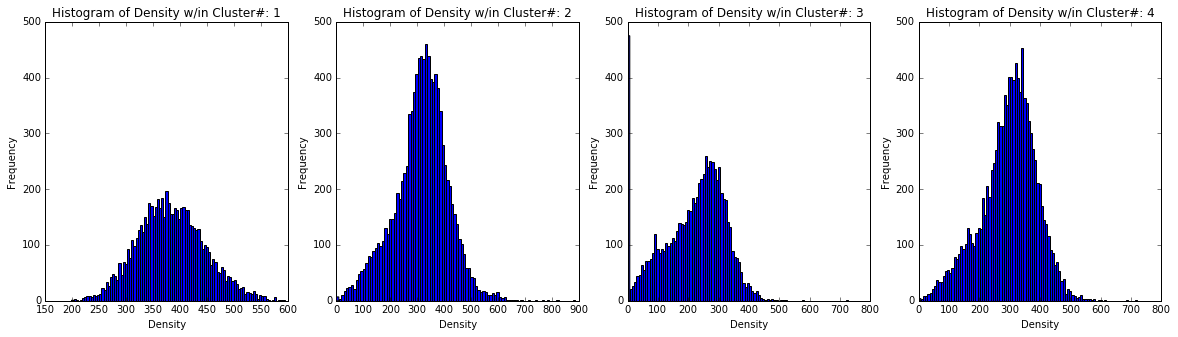

In [44]:
counter = 0
fig, axs = plt.subplots(1,4, figsize=(20,5))
for cluster in clusters:
    s = cluster.shape
    cluster = cluster.reshape((s[1], s[2]))
    counter += 1
    print 
    print'Working on cluster: ' + str(counter)
    X = cluster[:, (0,1,2)] # x,y,z
    Y = cluster[:,-1] # syn/unmasked from spike
    figure = plt.figure()
    axs[counter-1].hist(cluster[:,-1],100)
    axs[counter-1].set_title('Histogram of Density w/in Cluster#: '+ str(counter))
    axs[counter-1].set_xlabel('Density')
    axs[counter-1].set_ylabel('Frequency')
    axs[counter-1].set_ylim([0,500])
    
 
    print "Done with cluster"
plt.show()